In [1]:
import illustris_python as il
import glob, os
import numpy as np
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
from matplotlib import colors, cm

In [8]:
basePath = '/virgotng/mpia/TNG-Cluster/TNG-Cluster/output/'
snap = 99
halos = il.groupcat.loadHalos(basePath, snap)

In [9]:
mask = halos['GroupPrimaryZoomTarget']
main_halos = halos['GroupFirstSub'][mask.astype(bool)]

In [116]:
len(main_halos)

352

In [9]:
tree = il.lhalotree.loadTree(basePath, snap, main_halos[0])
tree

{'count': 19536,
 'Descendant': array([     -1,  675853,  675852, ..., 8037700, 8037701, 8037702],
       dtype=int32),
 'FileNr': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'FirstHaloInFOFGroup': array([ 675853,  675852,  675851, ..., 8037701, 8037702, 8037703],
       dtype=int32),
 'FirstProgenitor': array([ 675852,  675851,  675850, ..., 8037702, 8037703,      -1],
       dtype=int32),
 'GroupCM': array([[174436.45, 263208.53, 460490.7 ],
        [174484.55, 263235.34, 460562.34],
        [174558.3 , 263277.94, 460673.9 ],
        ...,
        [179967.52, 268169.03, 464861.8 ],
        [180083.39, 268305.94, 464908.88],
        [180216.36, 268421.47, 464993.5 ]], dtype=float32),
 'GroupMassType': array([[1.7945669e+03, 1.2864865e+04, 2.0291654e+03, 0.0000000e+00,
         2.1430664e+02, 1.3049657e+00],
        [1.7968007e+03, 1.2842626e+04, 1.9990175e+03, 0.0000000e+00,
         2.1404390e+02, 1.2953664e+00],
        [1.7921844e+03, 1.2759533e+04, 1.9762743e+03, 0.0000000e+00,
 

In [87]:
il.groupcat.loadHeader(basePath, snap)

{'BoxSize': 680000.0,
 'FlagDoubleprecision': 0,
 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699',
 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200',
 'HubbleParam': 0.6774,
 'Ngroups_ThisFile': 252455,
 'Ngroups_Total': 19453039,
 'Nids_ThisFile': 0,
 'Nids_Total': 0,
 'Nsubgroups_ThisFile': 138431,
 'Nsubgroups_Total': 10378451,
 'NumFiles': 352,
 'Omega0': 0.3089,
 'OmegaLambda': 0.6911,
 'Redshift': 0.0,
 'Time': 1.0}

In [3]:
from astropy.cosmology import Planck15

def find_halos_with_major_mergers(tree, rmin = 0.3, bmax = 500, by='fof', vmin=None):
    """
    bmax is in ckpc/h
    """
    merger_snaps = []
    h = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
    for snap in np.unique(tree['SnapNum']):
        z = il.groupcat.loadHeader(basePath, snap)['Redshift']
        a = Planck15.scale_factor(z)
        
        snapmask = tree['SnapNum'] == snap
        if by == 'fof':
            mass = tree['Group_M_Crit200'][snapmask] * 1e10/h #Msun
        else:
            mass = np.sum(tree['SubhaloMassType'], axis=1)[snapmask]
            
        pos   = tree['SubhaloPos'][snapmask] * a/h        #kpc
        vel = tree['SubhaloVel'][snapmask]                #km/s
        
        n_merge =  sum(mass > 0)
        if n_merge > 1:
            m0 = mass.max()
            # mass ratio criterion
            r = mass/m0
            rmask = (~np.isinf(r) * (r > rmin) * (r < 1))
            
            if sum(rmask):
                # print(len(rmask))
                #impact parameter criterion
                
                pos0 = pos[mass == m0]
                sep = pos - pos0
                # print(len(sep))
                dist = np.linalg.norm(sep, axis = 1)
                
                vel0 = vel[mass == m0]
                vrel = vel - vel0
                speed = np.linalg.norm(vrel, axis=1)

                dnorm = np.array([sep[i]/dist[i] for i in range(len(sep))])
                vnorm = np.array([vrel[i]/speed[i] for i in range(len(sep))])
                impact_angle = np.arccos(np.linalg.norm(np.multiply(dnorm, vnorm), axis=1))

                impact_parameter = np.sin(impact_angle)*dist

                bmask = (impact_parameter < bmax)
                # print(len(bmask), len(rmask))

                #add velocity criterion?
                if vmin:
                    vmask = (speed > vmin)
                else:
                    vmask = np.ones(len(bmask))

                if sum(rmask*bmask*vmask):
                        merger_snaps.append(snap)
                    
    return np.unique(np.array(merger_snaps))

In [96]:
mergers = find_halos_with_major_mergers(tree)    

/tmp/ipykernel_56915/2659688824.py:42: RuntimeWarning: invalid value encountered in divide
  dnorm = np.array([sep[i]/dist[i] for i in range(len(sep))])
/tmp/ipykernel_56915/2659688824.py:43: RuntimeWarning: invalid value encountered in divide
  vnorm = np.array([vrel[i]/speed[i] for i in range(len(sep))])


In [97]:
mergers_by_subfind = find_halos_with_major_mergers(tree, by='sub')

/tmp/ipykernel_56915/2659688824.py:42: RuntimeWarning: invalid value encountered in divide
  dnorm = np.array([sep[i]/dist[i] for i in range(len(sep))])
/tmp/ipykernel_56915/2659688824.py:43: RuntimeWarning: invalid value encountered in divide
  vnorm = np.array([vrel[i]/speed[i] for i in range(len(sep))])


In [98]:
mergers, mergers_by_subfind

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
        19], dtype=int32),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], dtype=int32))

In [4]:
import pandas as pd
df = pd.read_csv('../../dataset_raw/Xray-TNG-Cluster/label.csv')

In [196]:
# halo_mergers = {}
for halo in main_halos:
    if halo > 3985720:
        tree = il.lhalotree.loadTree(basePath, 99, halo)
        mergers = find_halos_with_major_mergers(tree, rmin=0.2)
        print(halo, "merger tree constructed")
        # mergers_with_img = [m for m in mergers if m in np.unique(df['snapshot_id'])]
        halo_mergers[halo] = mergers #_with_img
        with open('../../fiducial/postprocessing/bullet_mergers.pkl', 'wb') as f:
            pickle.dump(halo_mergers, f)

/tmp/ipykernel_56915/2659688824.py:42: RuntimeWarning: invalid value encountered in divide
  dnorm = np.array([sep[i]/dist[i] for i in range(len(sep))])
/tmp/ipykernel_56915/2659688824.py:43: RuntimeWarning: invalid value encountered in divide
  vnorm = np.array([vrel[i]/speed[i] for i in range(len(sep))])


4031397 merger tree constructed
4077072 merger tree constructed
4119827 merger tree constructed
4159199 merger tree constructed
4199701 merger tree constructed
4244652 merger tree constructed
4283462 merger tree constructed
4324318 merger tree constructed
4365298 merger tree constructed
4408132 merger tree constructed
4450680 merger tree constructed
4492019 merger tree constructed
4531455 merger tree constructed
4567157 merger tree constructed
4601291 merger tree constructed
4638692 merger tree constructed
4673562 merger tree constructed
4707705 merger tree constructed
4741747 merger tree constructed
4782967 merger tree constructed
4821818 merger tree constructed
4860257 merger tree constructed
4896930 merger tree constructed
4933014 merger tree constructed
4972234 merger tree constructed
5011983 merger tree constructed
5051011 merger tree constructed
5089598 merger tree constructed
5124055 merger tree constructed
5158948 merger tree constructed
5194845 merger tree constructed
5231748 

In [5]:
import pickle 

# with open('../../fiducial/postprocessing/bullet_mergers.pkl', 'wb') as f:
#     pickle.dump(halo_mergers, f)
        
with open('../../fiducial/postprocessing/bullet_mergers.pkl', 'rb') as f:
    halo_mergers = pickle.load(f)

In [65]:
print(np.unique(df['snapshot_id']))
for halo in main_halos:
    snaps = halo_mergers[halo]
    if len(snaps[snaps>49]):
        print(halo, snaps[snaps>49])

[50. 59. 67. 72. 78. 84. 91. 99.]
2830001 [81]
3080782 [91 96]
3817446 [63 64]
5902094 [53 54 57 58 59 66 67 69 94 95]
6737251 [86]
6844091 [51]
6897780 [86]
7469650 [71]
7571778 [76 86 90 94 97]
7929000 [84 85]
8021322 [79 80 81 84 88 93]
8474752 [60 61 62 63 64 65 66]
8622692 [98]
9152984 [75 77]
9249700 [79 80 81 82 83 84 85 86 87 88 90 91 92]
9611401 [58 59]
9664057 [77]
9717216 [79]
10140647 [50 51 52]
10183610 [58 59 60 61 63 64]
10292901 [74 75]
10358644 [50 85 87 88 89 90]


In [10]:
#next, plot these snapshots
mergers_with_imgs = {}
for halo in main_halos:
    snaps = halo_mergers[halo]
    images = [s for s in snaps if s in np.unique(df['snapshot_id'])]
    mergers_with_imgs[halo] = np.array(images)


In [14]:
current_bullets = {}
for halo in main_halos:
    if len(mergers_with_imgs[halo]):
        current_bullets[halo] =  mergers_with_imgs[halo]

In [152]:
def get_halo_num(subid, snapshot):
    tree2 = il.lhalotree.loadTree(basePath, 99, subid, onlyMPB=True)
    subid2 = tree2['SubhaloNumber'][tree2['SnapNum'] == snapshot]
    hnum = il.groupcat.loadSingle(basePath, snapshot, subhaloID=subid2)['SubhaloGrNr']
    return hnum

with open('../../fiducial/postprocessing/bullet_mergers_with_images.pkl', 'wb') as f:
    pickle.dump(mergers_with_imgs, f)
        
with open('../../fiducial/postprocessing/bullet_mergers_with_images.pkl', 'rb') as f:
    loaded_dict_im = pickle.load(f)

In [17]:
nmerge = 0
for halo in current_bullets.keys():
    nmerge += len(current_bullets[halo])
nmerge

11

In [154]:
for halo in current_bullets.keys():
    snaps = current_bullets[halo]
    for snap in snaps:
        print(halo, snap)
        try:
            print(get_halo_num(halo, snap))
        except:
            pass
        

3080782 91
5865691
5902094 59
5902094 67
7929000 84
15160903
8021322 84
15341007
9249700 84
17636454
9249700 91
17451240
9611401 59
18920986
10140647 50
20271842
10183610 59
20040882
10358644 50
20695044


In [92]:
import h5py
fits_dict = {}
fits_dict[40] = h5py.File('/virgotng/mpia/TNG-Cluster/TNG-Cluster/postprocessing/projections/gas-xray_lum_0.5-5.0kev_040_2r200_d=r200.hdf5')
for snap in np.unique(df['snapshot_id']):
    fits_dict[int(snap)] = h5py.File('/virgotng/mpia/TNG-Cluster/TNG-Cluster/postprocessing/projections/gas-xray_lum_0.5-5.0kev_0%d_2r200_d=r200.hdf5' % int(snap))

In [93]:
imkeys = [k for k in fits_dict.keys()]
imkeys

[40, 50, 59, 67, 72, 78, 84, 91, 99]

In [162]:
def get_z(snap):
    return il.groupcat.loadHeader(basePath, snap)['Redshift']
    
def plot(keynum, dict=current_bullets, vmin = 32, vmax=40):
    keys = [k for k in current_bullets.keys()]
    subid = keys[keynum]
    snaps = current_bullets[subid]
    if len(snaps)>0:
        snaps = snaps[0]
    print(subid, snaps)
    
    fig, ax = plt.subplots(nrows = 3, ncols = 3, sharey=True, sharex=True)
    
    imfile = fits_dict[int(snaps)]
    imkeys = [k for k in fits_dict.keys()]
    imkeys.sort()
    index = imkeys.index(snaps)
    hprev = get_halo_num(subid, imkeys[index-1])
    hnum = get_halo_num(subid, snaps)
    try:
        hnext = get_halo_num(subid, imkeys[index+1])
        imnext = fits_dict[imkeys[index+1]]
    except IndexError:
        pass
    # print(imkeys[index-1], imkeys[index], imkeys[index+1])
    imprev = fits_dict[imkeys[index-1]]
    
    for i in range(3):
        ax[0, i].imshow(imprev['Halo_%d' % int(hprev)][:,:,i], cmap = cm.magma, norm=colors.Normalize(vmin, vmax))
        ax[1, i].imshow(imfile['Halo_%d' % int(hnum)][:,:,i], cmap = cm.magma, norm=colors.Normalize(vmin, vmax))
        try:
            ax[2, i].imshow(imnext['Halo_%d' % int(hnext)][:,:,i], cmap = cm.magma, norm=colors.Normalize(vmin, vmax))
        except UnboundLocalError:
            pass
        try:
            ax[i, 0].text(250, 1750, 'z = %0.2f' % get_z(imkeys[index+i-1]), color='w')
        except IndexError:
            pass
    if index == (len(imkeys) - 1):
        for i in range(3):
            ax[2,i].remove()
    plt.savefig('../../temp/bullet_hnum%d_snap%d.png' % (hnum, snaps), dpi=192)

3080782 91


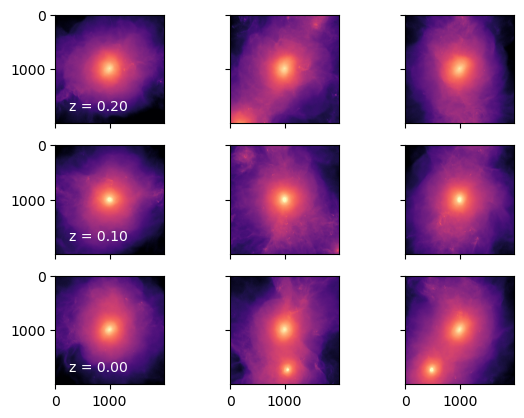

In [163]:
plot(0)

7929000 84


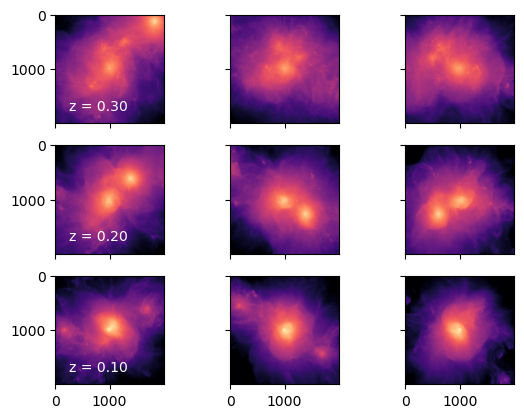

In [164]:
plot(2)

8021322 84


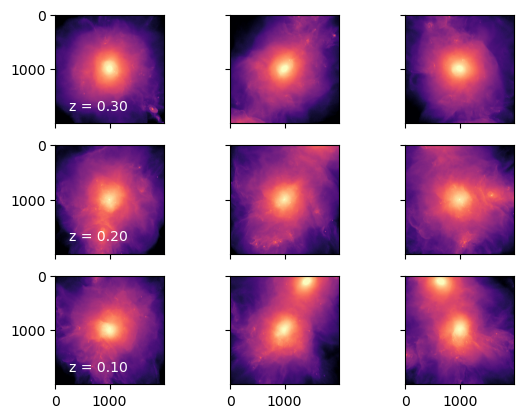

In [165]:
plot(3, vmax=39)

10140647 50


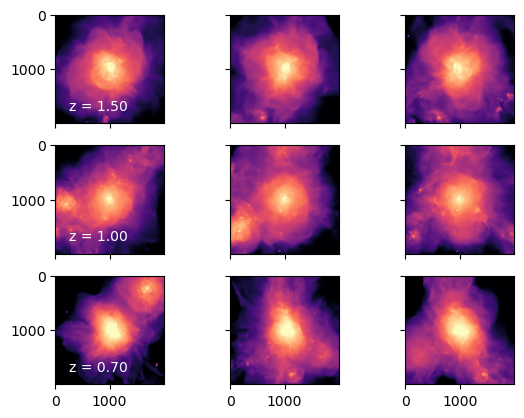

In [166]:
plot(6,vmax=38)

10183610 59


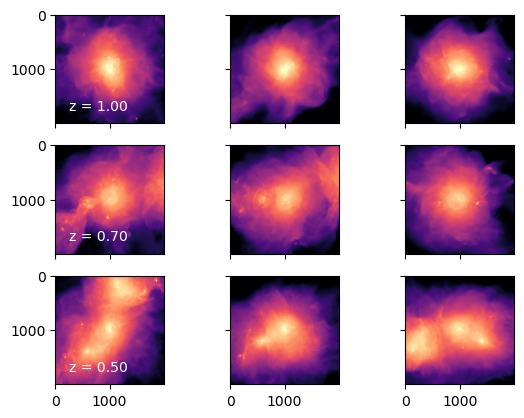

In [167]:
plot(7, vmax=38)

In [59]:
keys = [k for k in current_bullets.keys()]
current_bullets[keys[1]], current_bullets[keys[4]]

(array([59, 67], dtype=int32), array([84, 91], dtype=int32))

In [90]:
#these are the only subids with two snapshots of interest
#that's where the function is going wrong 
/virgotng/mpia/TNG-Cluster/TNG-Cluster/postprocessing/projections/gas-xray_lum_0.5-5.0kev_040_2r200_d\=r200.hdf5

array([50., 59., 67., 72., 78., 84., 91., 99.])